# CycleGAN Homework Task List

In this HW, you will implement a CycleGAN for selfie-to-anime and anime-to-selfie unpaired translations.  
You can read more about CycleGANs [here](https://machinelearningmastery.com/what-is-cyclegan/).

## 1. Dataset and Environment Setup
- [ ] Download the provided dataset (code for this is provided below) .
- [ ] Organize the dataset into appropriate training and test folders (if not already done).

## 2. Model Implementation
- [ ] Implement the Generator and Discriminator models.
- [ ] Define the loss functions:
  - Adversarial Loss
  - Cycle Consistency Loss
  - Identity Loss
- [ ] Integrate all components into a full CycleGAN training pipeline.



## 4. Training the CycleGAN
- [ ] Choose and configure training hyperparameters (e.g., learning rate, batch size, epochs).
- [ ] Train your model using the training set.
- [ ] Visualize training progress with sample outputs and loss plots.

## 5. Evaluation on Test Set
- [ ] Generate and display 10 **selfie-to-anime** translations using test set images.
- [ ] Generate and display 10 **anime-to-selfie** translations using test set images.

## 6. Evaluation on Internet Images
- [ ] Select 3 random selfie images from the internet.
- [ ] Select 3 random anime images from the internet.
- [ ] Run both **selfie-to-anime** and **anime-to-selfie** translations on these images.
- [ ] Display or save the outputs.



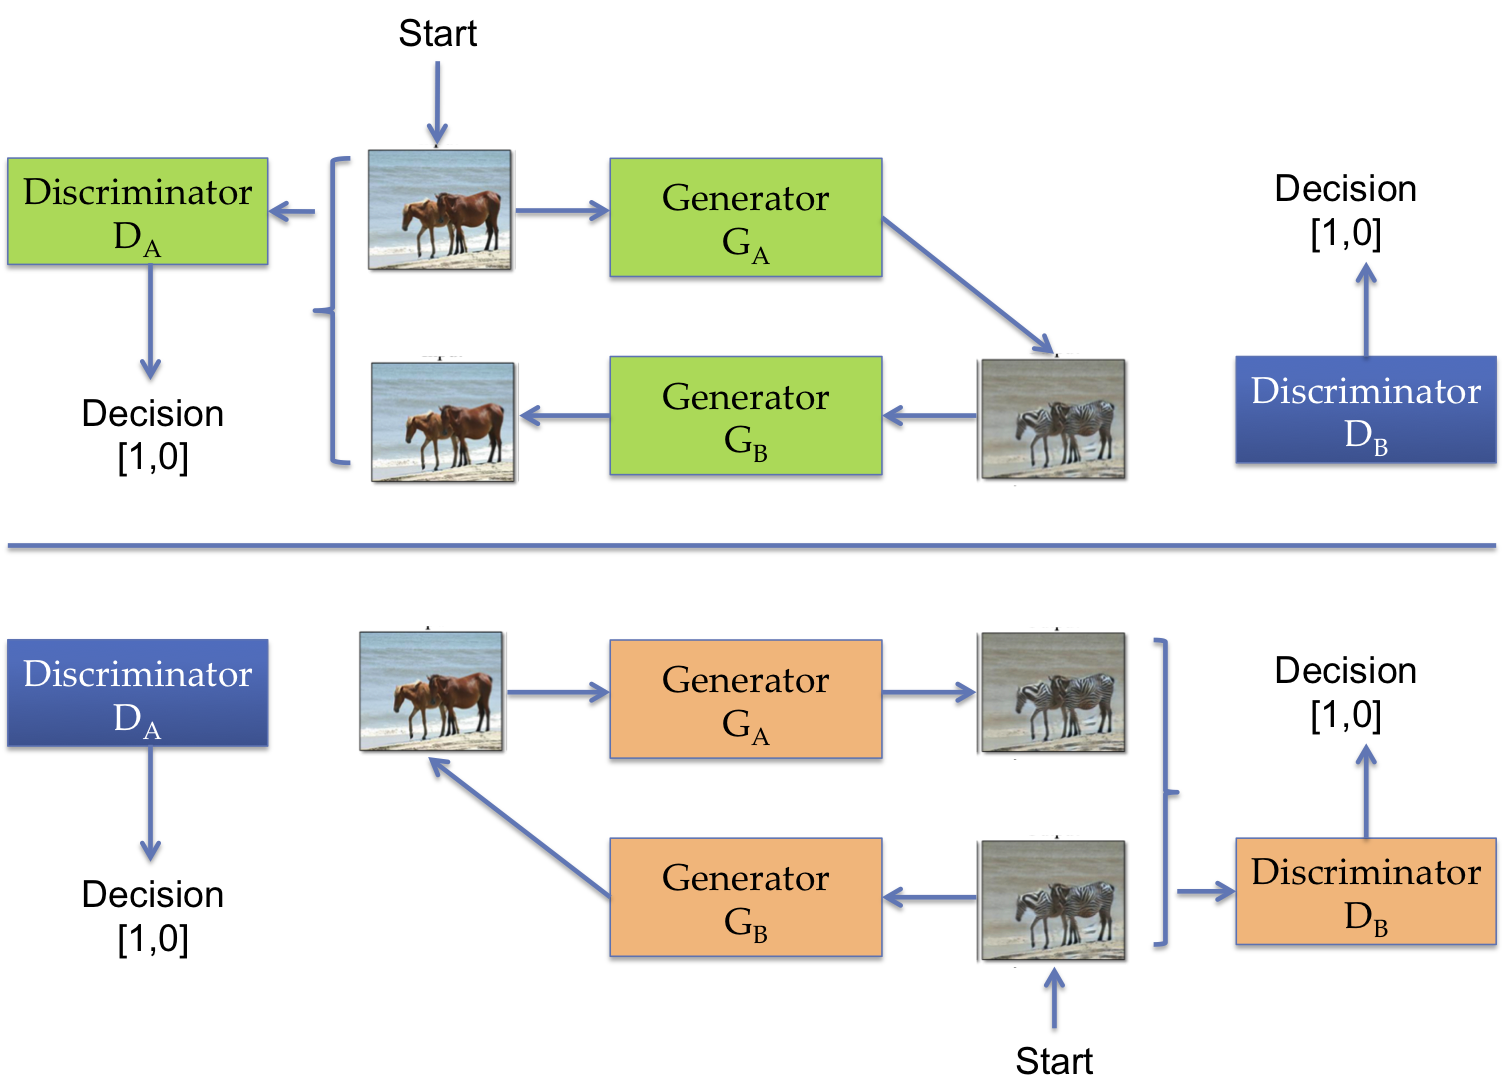

[Image Source](https://www.oreilly.com/library/view/hands-on-artificial-intelligence/9781788836067/c2e7d914-4e45-4528-8627-c590d19107ef.xhtml)

In [41]:
!gdown "1xOWj1UVgp6NKMT3HbPhBbtq2A4EDkghF"

Downloading...
From (original): https://drive.google.com/uc?id=1xOWj1UVgp6NKMT3HbPhBbtq2A4EDkghF
From (redirected): https://drive.google.com/uc?id=1xOWj1UVgp6NKMT3HbPhBbtq2A4EDkghF&confirm=t&uuid=edab6c51-8a18-4fe2-a43b-fc8ba1c9438d
To: /Users/kaichen/Desktop/selfie2anime.zip
100%|████████████████████████████████████████| 409M/409M [00:11<00:00, 35.6MB/s]


In [ ]:
!unzip selfie2anime.zip

Archive:  selfie2anime.zip
replace testA/female_10328.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# 导入所有必要的库
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
import os
import glob
from tqdm.notebook import tqdm

# 设置随机种子
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# 检查设备可用性并打印
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS device for Apple Silicon GPU acceleration.")
else:
    device = torch.device("cpu")
    print("MPS device not found, falling back to CPU.")
print(f"当前使用的设备是: {device}")

# 定义配置参数
IMG_SIZE = 128  # 图像尺寸
BATCH_SIZE = 16  # 批量大小
LEARNING_RATE = 0.0002  # 学习率
BETA1 = 0.5  # Adam优化器的beta1参数
BETA2 = 0.999  # Adam优化器的beta2参数
LAMBDA_CYCLE = 10  # 循环一致性损失的权重
LAMBDA_IDENTITY = 5 # 身份损失的权重
NUM_EPOCHS = 100  # 训练周期数

DATASET_PATH = ""

Using MPS device for Apple Silicon GPU acceleration.
当前使用的设备是: mps


In [ ]:
# 创建自定义数据集类
class UnpairedImageDataset(Dataset):
    def __init__(self, root_A, root_B, transform=None):
        self.root_A = root_A
        self.root_B = root_B
        # A: Selfie; B: Anime
        self.transform = transform
        self.images_A = sorted(glob.glob(os.path.join(root_A, "*.*")))
        self.images_B = sorted(glob.glob(os.path.join(root_B, "*.*")))

    def __len__(self):
        return max(len(self.images_A), len(self.images_B))

    def __getitem__(self, idx):
        # 为了处理两个域图像数量不一致的情况，使用随机索引
        img_A = Image.open(self.images_A[idx % len(self.images_A)]).convert('RGB')
        # 从域 A 中获取一张图片。idx % len(self.images_A) 确保即使 idx 超过了域 A 的图片数量，也能循环地从 images_A 中取图，避免索引越界。
        img_B = Image.open(self.images_B[random.randint(0, len(self.images_B) - 1)]).convert('RGB')
        # 从域 B 中随机获取一张图片。random.randint(0, len(self.images_B) - 1) 是关键。它表明在每个训练批次中，从域 A 取出的图像 img_A 与从域 B 中取出的图像 img_B 之间是随机匹配的，没有固定的对应关系。

        if self.transform:
            img_A = self.transform(img_A)
            img_B = self.transform(img_B)

        return img_A, img_B

In [ ]:
# 定义图像转换
transforms_ = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# 创建训练和测试数据集
train_dataset = UnpairedImageDataset(
    root_A=os.path.join(DATASET_PATH, 'trainA'),
    root_B=os.path.join(DATASET_PATH, 'trainB'),
    transform=transforms_
)

test_dataset = UnpairedImageDataset(
    root_A=os.path.join(DATASET_PATH, 'testA'),
    root_B=os.path.join(DATASET_PATH, 'testB'),
    transform=transforms_
)

# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"训练数据集大小: {len(train_dataset)}")
print(f"测试数据集大小: {len(test_dataset)}")

训练数据集大小: 3400
测试数据集大小: 100


In [ ]:
# 生成器 (U-Net)
class GeneratorUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(GeneratorUNet, self).__init__()

        # Encoder
        self.enc1 = nn.Sequential(nn.Conv2d(in_channels, 64, 4, 2, 1), nn.LeakyReLU(0.2))
        self.enc2 = nn.Sequential(nn.Conv2d(64, 128, 4, 2, 1), nn.InstanceNorm2d(128), nn.LeakyReLU(0.2))
        # BN 在一个批次 (batch) 的所有样本上，对每个通道独立地计算均值和方差。
        # IN 在训练和推理时都使用当前实例的统计量。因此，IN 没有批次大小的限制，也不需要维护全局的运行统计量。
        self.enc3 = nn.Sequential(nn.Conv2d(128, 256, 4, 2, 1), nn.InstanceNorm2d(256), nn.LeakyReLU(0.2))
        self.enc4 = nn.Sequential(nn.Conv2d(256, 512, 4, 2, 1), nn.InstanceNorm2d(512), nn.LeakyReLU(0.2))
        self.enc5 = nn.Sequential(nn.Conv2d(512, 512, 4, 2, 1), nn.InstanceNorm2d(512), nn.LeakyReLU(0.2))
        self.enc6 = nn.Sequential(nn.Conv2d(512, 512, 4, 2, 1), nn.InstanceNorm2d(512), nn.LeakyReLU(0.2))
        self.bottleneck = nn.Sequential(nn.Conv2d(512, 512, 4, 2, 1), nn.ReLU())

        # Decoder
        self.dec1 = nn.Sequential(nn.ConvTranspose2d(512, 512, 4, 2, 1), nn.InstanceNorm2d(512), nn.ReLU(), nn.Dropout(0.5))
        self.dec2 = nn.Sequential(nn.ConvTranspose2d(1024, 512, 4, 2, 1), nn.InstanceNorm2d(512), nn.ReLU(), nn.Dropout(0.5))
        self.dec3 = nn.Sequential(nn.ConvTranspose2d(1024, 512, 4, 2, 1), nn.InstanceNorm2d(512), nn.ReLU(), nn.Dropout(0.5))
        self.dec4 = nn.Sequential(nn.ConvTranspose2d(1024, 256, 4, 2, 1), nn.InstanceNorm2d(256), nn.ReLU())
        self.dec5 = nn.Sequential(nn.ConvTranspose2d(512, 128, 4, 2, 1), nn.InstanceNorm2d(128), nn.ReLU())
        self.dec6 = nn.Sequential(nn.ConvTranspose2d(256, 64, 4, 2, 1), nn.InstanceNorm2d(64), nn.ReLU())
        self.final = nn.Sequential(nn.ConvTranspose2d(128, out_channels, 4, 2, 1), nn.Tanh())

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)
        e4 = self.enc4(e3)
        e5 = self.enc5(e4)
        e6 = self.enc6(e5)

        bottleneck = self.bottleneck(e6)

        d1 = self.dec1(bottleneck)
        d1 = torch.cat((d1, e6), 1)
        d2 = self.dec2(d1)
        d2 = torch.cat((d2, e5), 1)
        d3 = self.dec3(d2)
        d3 = torch.cat((d3, e4), 1)
        d4 = self.dec4(d3)
        d4 = torch.cat((d4, e3), 1)
        d5 = self.dec5(d4)
        d5 = torch.cat((d5, e2), 1)
        d6 = self.dec6(d5)
        d6 = torch.cat((d6, e1), 1)

        return self.final(d6)

In [ ]:
# 判别器 (PatchGAN)
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, normalize=True):
            # in_filters: 输入特征图的通道数。
            # out_filters: 输出特征图的通道数。
            # normalize: 一个布尔值，如果为 True，则在卷积层后添加 Instance Normalization。默认为 True。
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            # 4: 卷积核的大小为 4x4。
            # stride=2: 步长为 2。这意味着卷积核每次移动 2 个像素，这会导致特征图的尺寸减半。
            # padding=1: 填充大小为 1。这会在输入特征图的边缘添加 1 像素的零填充，有助于保持特征图的空间信息。
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(in_channels, 64, normalize=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1)
        )

    def forward(self, img):
        return self.model(img)

Remark: 判别器设计考虑了上述 IN 在 GANs 中可能带来的优势，特别是当判别器需要更专注于单个生成图像的真实性，而不是依赖于批次统计时。这有助于避免批次伪影，并可能促进生成器生成更多样化的图像。

In [ ]:
# 初始化生成器和判别器
G_AB = GeneratorUNet().to(device)  # A -> B
G_BA = GeneratorUNet().to(device)  # B -> A
D_A = Discriminator().to(device)  # Discriminator for domain A
D_B = Discriminator().to(device)  # Discriminator for domain B

# 权重初始化
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

G_AB.apply(weights_init)
G_BA.apply(weights_init)
D_A.apply(weights_init)
D_B.apply(weights_init)

print("模型初始化完成。")

# 损失函数
criterion_GAN = nn.MSELoss()
criterion_cycle = nn.L1Loss()
criterion_identity = nn.L1Loss()

# 优化器
optimizer_G = optim.Adam(
    list(G_AB.parameters()) + list(G_BA.parameters()),
    lr=LEARNING_RATE,
    betas=(BETA1, BETA2)
)
optimizer_D_A = optim.Adam(D_A.parameters(), lr=LEARNING_RATE, betas=(BETA1, BETA2))
optimizer_D_B = optim.Adam(D_B.parameters(), lr=LEARNING_RATE, betas=(BETA1, BETA2))

模型初始化完成。


**对抗性损失 (Adversarial Loss):**

1. 任务: 确保“英译法”翻译器（G_AB）翻译出的法语句子（生成的斑马图）看起来像一个地道的法国人写的（看起来像一张真实的斑马图）。

2. 监督者: 一个只懂法语的审稿人（判别器 D_B）。

**循环一致性损失 (Cycle-Consistency Loss):**

1. 任务: 确保翻译过程没有丢失原文的核心意思。它会把一个英文句子翻译成法文，再从法文翻译回英文，然后对比翻译回来的英文句子和原始的英文句子是否一致。英文 -> 法文 -> 英文 应该等于 原始英文。

2. 监督者: 对比原文和最终译文的系统。

**恒等损失 (Identity Loss):**

1. 任务: 这是一个额外的、用于提升翻译质量的“测试”。我们给“英译法”翻译器（G_AB）一个已经是法文的句子（一张真实的斑马图），然后要求它不要做任何改动，直接原文输出。

2. 为什么这么做？: 一个优秀的翻译器在看到已经是目标语言的内容时，应该有能力识别出“这无需翻译”，并保持其原样。如果它画蛇添足，强行“翻译”并弄乱了句子，那说明它的能力还不够稳定。

3. 监督者: 对比输入和输出是否一致的系统。



In [ ]:
def train_cycle_gan():
    """
    Trains the CycleGAN model and displays progress using tqdm.
    """
    print(f"开始训练 {NUM_EPOCHS} 个周期...")
    g_losses = []
    d_losses = []

    # Wrap the epochs loop with tqdm for an outer progress bar
    for epoch in tqdm(range(NUM_EPOCHS), desc="总训练进度 (Overall Progress)"):

        # Create a tqdm progress bar for the dataloader
        pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"周期 {epoch+1}/{NUM_EPOCHS}")

        for i, (real_A, real_B) in pbar:
            real_A = real_A.to(device)
            real_B = real_B.to(device)

            # The discriminator output size is 8x8, so the target size should be 8x8 as well
            target_real = torch.ones(real_A.size(0), 1, 8, 8, device=device)
            target_fake = torch.zeros(real_A.size(0), 1, 8, 8, device=device)

            # ---------------------
            #  训练生成器 (Train Generators)
            # ---------------------
            optimizer_G.zero_grad()

            # Identity loss
            loss_id_A = criterion_identity(G_BA(real_A), real_A)
            loss_id_B = criterion_identity(G_AB(real_B), real_B)
            loss_identity = (loss_id_A + loss_id_B) / 2

            # GAN loss
            fake_B = G_AB(real_A)
            loss_GAN_AB = criterion_GAN(D_B(fake_B), target_real)
            fake_A = G_BA(real_B)
            loss_GAN_BA = criterion_GAN(D_A(fake_A), target_real)
            loss_GAN = (loss_GAN_AB + loss_GAN_BA) / 2

            # Cycle consistency loss
            recovered_A = G_BA(fake_B)
            loss_cycle_A = criterion_cycle(recovered_A, real_A)
            recovered_B = G_AB(fake_A)
            loss_cycle_B = criterion_cycle(recovered_B, real_B)
            loss_cycle = (loss_cycle_A + loss_cycle_B) / 2

            # Total generator loss
            loss_G = loss_GAN + LAMBDA_CYCLE * loss_cycle + LAMBDA_IDENTITY * loss_identity
            loss_G.backward()
            optimizer_G.step()

            # ---------------------
            #  训练判别器 A (Train Discriminator A)
            # ---------------------
            optimizer_D_A.zero_grad()
            loss_D_real_A = criterion_GAN(D_A(real_A), target_real)
            loss_D_fake_A = criterion_GAN(D_A(fake_A.detach()), target_fake)
            loss_D_A = (loss_D_real_A + loss_D_fake_A) * 0.5
            loss_D_A.backward()
            optimizer_D_A.step()

            # ---------------------
            #  训练判别器 B (Train Discriminator B)
            # ---------------------
            optimizer_D_B.zero_grad()
            loss_D_real_B = criterion_GAN(D_B(real_B), target_real)
            loss_D_fake_B = criterion_GAN(D_B(fake_B.detach()), target_fake)
            loss_D_B = (loss_D_real_B + loss_D_fake_B) * 0.5
            loss_D_B.backward()
            optimizer_D_B.step()

            total_loss_D = (loss_D_A + loss_D_B) / 2

            # 记录损失 (Record losses)
            g_losses.append(loss_G.item())
            d_losses.append(total_loss_D.item())

            # Update the progress bar description with the latest losses
            pbar.set_description(
                f"周期 {epoch+1}/{NUM_EPOCHS} | "
                f"D 损失: {total_loss_D.item():.4f} | "
                f"G 损失: {loss_G.item():.4f} "
                f"(GAN: {loss_GAN.item():.4f}, Cycle: {loss_cycle.item():.4f}, ID: {loss_identity.item():.4f})"
            )

    return g_losses, d_losses

# 开始训练 (Start Training) 🚀
g_losses, d_losses = train_cycle_gan()

开始训练 100 个周期...


总训练进度 (Overall Progress):   0%|          | 0/100 [00:00<?, ?it/s]

周期 1/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 2/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 3/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 4/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 5/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 6/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 7/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 8/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 9/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 10/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 11/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 12/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 13/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 14/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 15/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 16/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 17/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 18/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 19/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 20/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 21/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 22/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 23/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 24/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 25/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 26/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 27/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 28/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 29/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 30/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 31/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 32/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 33/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 34/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 35/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 36/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 37/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 38/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 39/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 40/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 41/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 42/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 43/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 44/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 45/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 46/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 47/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 48/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 49/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 50/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 51/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 52/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 53/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 54/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 55/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 56/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 57/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 58/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 59/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 60/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 61/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 62/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 63/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 64/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 65/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 66/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 67/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 68/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 69/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 70/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 71/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 72/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 73/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 74/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 75/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 76/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 77/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 78/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 79/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 80/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 81/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 82/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 83/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 84/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 85/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 86/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 87/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 88/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 89/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 90/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 91/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 92/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 93/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 94/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 95/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 96/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 97/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 98/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 99/100:   0%|          | 0/213 [00:00<?, ?it/s]

周期 100/100:   0%|          | 0/213 [00:00<?, ?it/s]

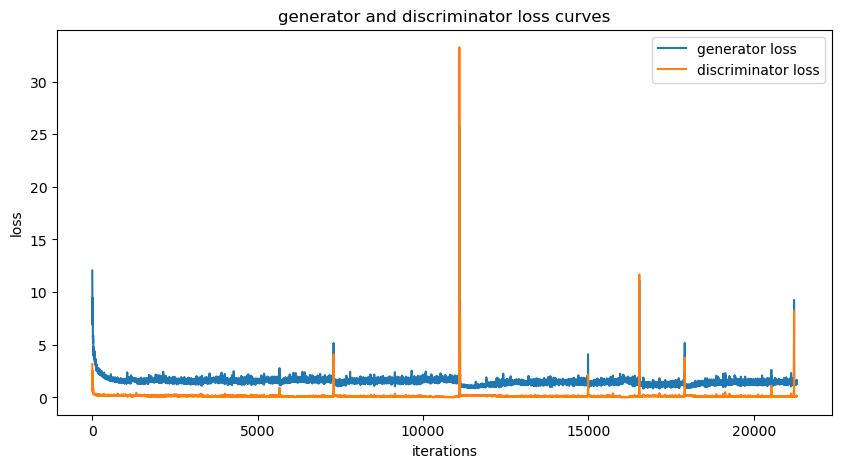


在测试集上展示10张翻译结果...


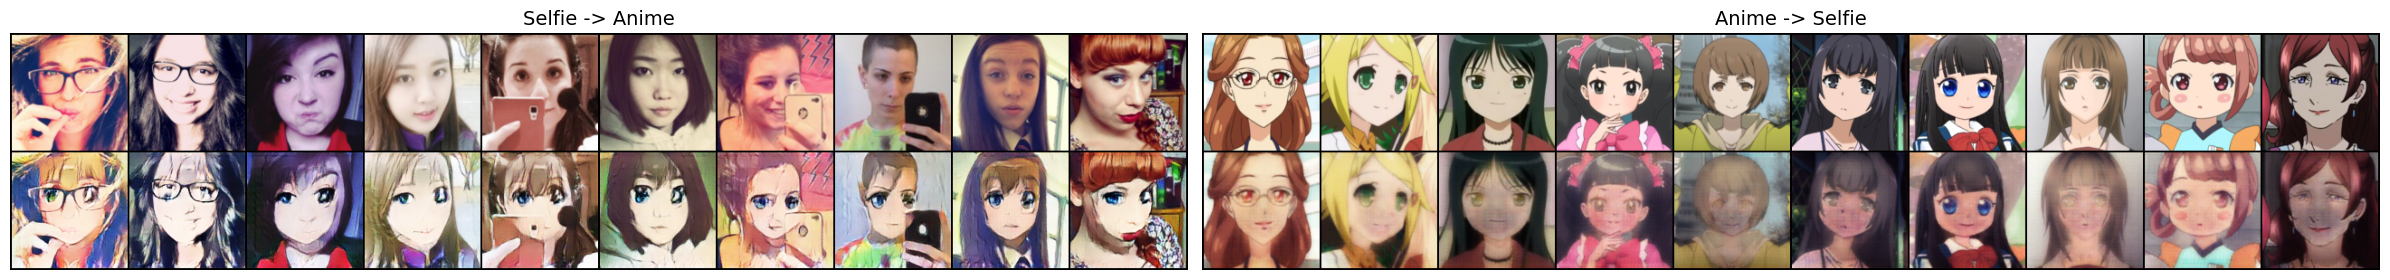

In [ ]:
# 绘制损失曲线
plt.figure(figsize=(10, 5))
plt.title("generator and discriminator loss curves")
plt.plot(g_losses, label="generator loss")
plt.plot(d_losses, label="discriminator loss")
plt.xlabel("iterations")
plt.ylabel("loss")
plt.legend()
plt.show()

# --- 修改后的函数：生成和展示翻译结果 ---
def show_translation_results(loader, num_images=10):
    """
    修改后的函数，可以从数据加载器中获取指定数量的图片并展示。
    """
    # 确保模型处于评估模式
    # G_AB: Selfie -> Anime, G_BA: Anime -> Selfie
    G_AB.eval()
    G_BA.eval()

    # --- 数据获取 ---
    # 从数据加载器中循环获取，直到有足够数量的图片
    real_A_list, real_B_list = [], []
    data_iter = iter(loader)
    while len(real_A_list) < num_images:
        try:
            # 假设加载器每次返回(real_A, real_B)两个批次
            real_A_batch, real_B_batch = next(data_iter)
            real_A_list.extend(real_A_batch)
            real_B_list.extend(real_B_batch)
        except StopIteration:
            print("数据加载器已遍历完，无法获取更多图片。")
            break
    
    # 裁切成正好需要的数量，并拼接成一个Tensor
    real_A_tensor = torch.stack(real_A_list[:num_images]).to(device)
    real_B_tensor = torch.stack(real_B_list[:num_images]).to(device)

    # --- 执行翻译 ---
    with torch.no_grad(): # 在此模式下不计算梯度，节约资源
        fake_B_tensor = G_AB(real_A_tensor)
        fake_A_tensor = G_BA(real_B_tensor)

    # --- 图像处理与显示 ---
    # 反归一化函数
    def denorm(x):
        out = (x + 1) / 2
        return out.clamp(0, 1)

    # 拼接原图和生成图，用于网格显示
    # 上面一行是原图，下面一行是生成图
    img_sample_A_to_B = torch.cat((denorm(real_A_tensor.data), denorm(fake_B_tensor.data)), 0)
    img_sample_B_to_A = torch.cat((denorm(real_B_tensor.data), denorm(fake_A_tensor.data)), 0)
    
    # 调整画布大小以适应10张图片
    plt.figure(figsize=(24, 6))

    # Selfie -> Anime
    plt.subplot(1, 2, 1)
    plt.title(f"Selfie -> Anime", fontsize=14)
    plt.imshow(np.transpose(vutils.make_grid(img_sample_A_to_B, nrow=num_images).cpu(), (1, 2, 0)))
    plt.xlabel("上: 原始真人图, 下: 生成动漫图", fontsize=12)
    plt.axis('off')

    # Anime -> Selfie
    plt.subplot(1, 2, 2)
    plt.title(f"Anime -> Selfie", fontsize=14)
    plt.imshow(np.transpose(vutils.make_grid(img_sample_B_to_A, nrow=num_images).cpu(), (1, 2, 0)))
    plt.xlabel("上: 原始动漫图, 下: 生成真人图", fontsize=12)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# --- 修改后的函数调用 ---
# 在测试集上展示结果
print("\n在测试集上展示10张翻译结果...")
show_translation_results(test_loader, num_images=10) # 传入 num_images=10

Remark: This training process is extremely unstable. The unusual action of the loss curves might arise from some mode collapses appeared.

**It's difficult to attain Nash equilibrium!**

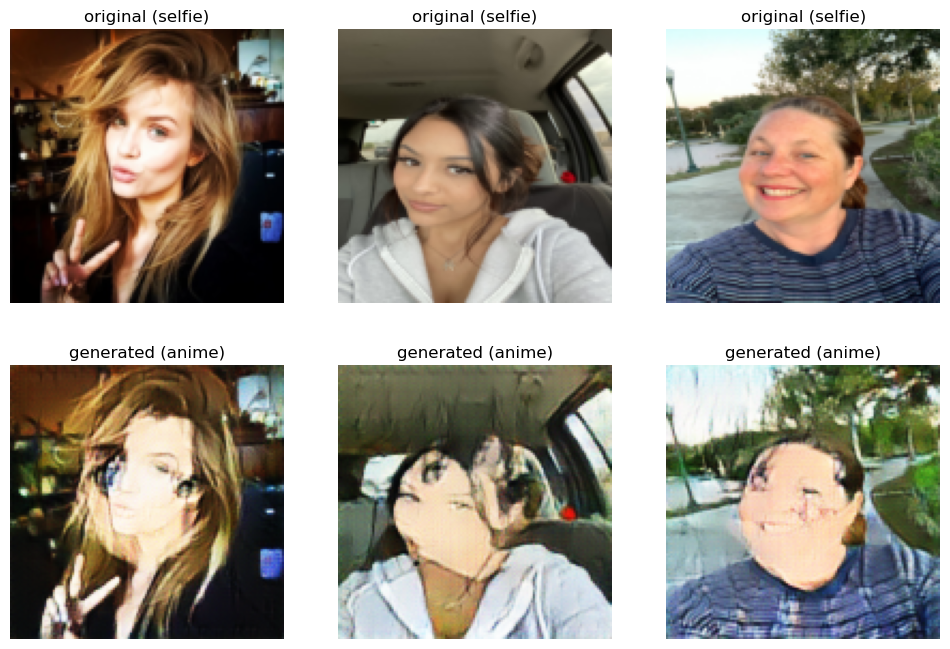

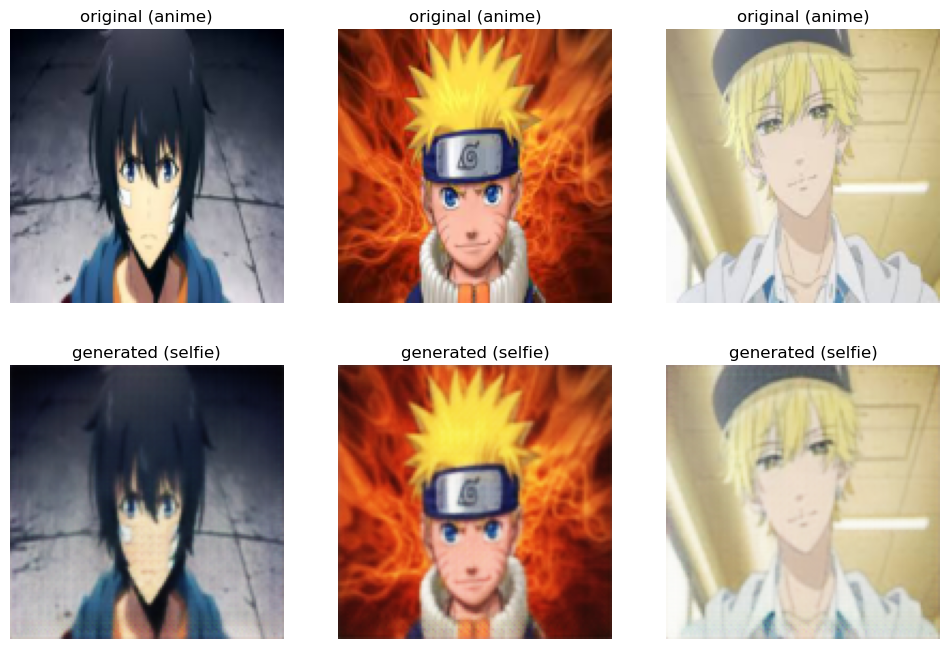

In [ ]:
# 在网络图片上进行评估
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

def translate_and_display_internet_images(image_paths_A, image_paths_B):
    transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    images_A = [transform(Image.open(p).convert('RGB')).unsqueeze(0).to(device) for p in image_paths_A]
    images_B = [transform(Image.open(p).convert('RGB')).unsqueeze(0).to(device) for p in image_paths_B]

    G_AB.eval()
    G_BA.eval()

    plt.figure(figsize=(12, 8))

    for i, img_A in enumerate(images_A):
        fake_B = G_AB(img_A)
        plt.subplot(2, len(images_A), i + 1)
        plt.imshow(np.transpose(denorm(img_A.squeeze(0).cpu()).detach().numpy(), (1, 2, 0)))
        plt.title("original (selfie)")
        plt.axis('off')

        plt.subplot(2, len(images_A), i + 1 + len(images_A))
        plt.imshow(np.transpose(denorm(fake_B.squeeze(0).cpu()).detach().numpy(), (1, 2, 0)))
        plt.title("generated (anime)")
        plt.axis('off')

    plt.show()

    plt.figure(figsize=(12, 8))

    for i, img_B in enumerate(images_B):
        fake_A = G_BA(img_B)
        plt.subplot(2, len(images_B), i + 1)
        plt.imshow(np.transpose(denorm(img_B.squeeze(0).cpu()).detach().numpy(), (1, 2, 0)))
        plt.title("original (anime)")
        plt.axis('off')

        plt.subplot(2, len(images_B), i + 1 + len(images_B))
        plt.imshow(np.transpose(denorm(fake_A.squeeze(0).cpu()).detach().numpy(), (1, 2, 0)))
        plt.title("generated (selfie)")
        plt.axis('off')

    plt.show()

internet_selfies = ['DATASET/Internet_Photos/selfie_1.jpg', 'DATASET/Internet_Photos/selfie_2.jpg', 'DATASET/Internet_Photos/selfie_3.jpg']
internet_animes = ['DATASET/Internet_Photos/anime_1.jpg', 'DATASET/Internet_Photos/anime_2.jpg', 'DATASET/Internet_Photos/anime_3.jpg']
translate_and_display_internet_images(internet_selfies, internet_animes)